<a href="https://colab.research.google.com/github/JoshHemmerling/Python-Codes/blob/Mesoclimate-research-project/klbbML_moc_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier # Import LightGBM

# --- Data Loading and Preprocessing ---
# Load CSV
df = pd.read_csv("KLBB_wrf_2d_May_Aug1998.csv", encoding='latin1', low_memory=False)
print(f"Shape before handling NaNs: {df.shape}")

# Drop the 'Unnamed: 0' and 'XTIME' columns if they exist
columns_to_drop_initial = ['Unnamed: 0', 'XTIME']
df = df.drop(columns=columns_to_drop_initial, errors='ignore')

# Drop specified columns and the columns that were found to be all NaNs
columns_to_drop_additional = ['afwa_tlyrbot', 'afwa_afwa_tlyrtop', 'afwa_turb', 'C1H', 'C2H', 'C1F', 'C2F', 'C3H', 'C4H', 'C3F', 'C4F', 'AFWA_TLYRBOT', 'AFWA_TLYRTOP', 'AFWA_TURB']
df = df.drop(columns=columns_to_drop_additional, errors='ignore') # Use errors='ignore' in case some columns are not present
print(f"Shape after dropping specified columns and all-NaN columns: {df.shape}")

# Replace placeholder values with NaN
df = df.replace(-9.999000e+30, np.nan)

# Keep only numeric columns, including 'UP_HELI_MAX'
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
if 'UP_HELI_MAX' in df.columns and 'UP_HELI_MAX' not in numeric_cols:
    numeric_cols.append('UP_HELI_MAX')
df = df[numeric_cols]
print(f"Shape after dropping non-numeric columns (keeping UP_HELI_MAX): {df.shape}")

# Fill remaining missing values with the mean
df = df.fillna(df.mean())
print(f"Shape after filling remaining NaNs: {df.shape}")

# Check for remaining NaNs
print("Checking for remaining NaNs:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Set target
target = 'UP_HELI_MAX'
features = [col for col in df.columns if col not in [target]]

# Prepare data
X = df[features]
y = df[target]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# --- Multi-class Classification Target Creation (based on Percentiles) ---
# Examine the distribution of non-zero UP_HELI_MAX values
y_events = y[y > 0]

print("\nDistribution of non-zero UP_HELI_MAX values:")
print(y_events.describe())

# Calculate percentile thresholds for non-zero UP_HELI_MAX values
# Add a check to ensure y_events is not empty before calculating percentiles
if not y_events.empty:
    threshold_light_percentile = y_events.quantile(0.50)
    threshold_moderate_percentile = y_events.quantile(0.75)
    threshold_heavy_percentile = y_events.quantile(0.90)

    print(f"\nPercentile thresholds for non-zero UP_HELI_MAX:")
    print(f"50th percentile (potential Light storm threshold): {threshold_light_percentile:.2f}")
    print(f"75th percentile (potential Moderate storm threshold): {threshold_moderate_percentile:.2f}")
    print(f"90th percentile (potential Heavy storm threshold): {threshold_heavy_percentile:.2f}")

    # Create the multi-class target variable based on UP_HELI_MAX thresholds derived from percentiles
    def categorize_storm_intensity_percentile(up_heli_max, light_thresh, moderate_thresh, heavy_thresh):
        if up_heli_max == 0:
            return 0 # No storm
        elif up_heli_max <= light_thresh:
            return 1 # Light storm
        elif up_heli_max <= moderate_thresh:
            return 2 # Moderate storm
        elif up_heli_max <= heavy_thresh:
            return 3 # Heavy storm
        else:
            return 4 # Very Heavy Storm

    y_intensity_percentile = y.apply(categorize_storm_intensity_percentile,
                                      args=(threshold_light_percentile,
                                            threshold_moderate_percentile,
                                            threshold_heavy_percentile))

    # Check the distribution of the new multi-class target variable
    print("\nDistribution of Storm Intensity Categories (based on Percentiles):")
    print(y_intensity_percentile.value_counts().sort_index())


    # --- Multi-class LightGBM Classifier Training and Evaluation ---
    # Train-test split for multi-class classification
    X_train_intensity_perc, X_test_intensity_perc, y_train_intensity_perc, y_test_intensity_perc = train_test_split(
        X_scaled, y_intensity_percentile, test_size=0.2, random_state=42, stratify=y_intensity_percentile # Stratify by the new multi-class target
    )

    # Train a Multi-class LightGBM Classifier
    lgbm_intensity_classifier = LGBMClassifier(objective='multiclass',
                                               num_class=len(np.unique(y_train_intensity_perc)),
                                               metric='multi_logloss',
                                               random_state=42,
                                               n_jobs=-1)

    lgbm_intensity_classifier.fit(X_train_intensity_perc, y_train_intensity_perc)

    # Predict on the test set
    y_pred_lgbm_intensity = lgbm_intensity_classifier.predict(X_test_intensity_perc)

    # Evaluate the multi-class LightGBM classifier
    print("\n--- Multi-class Classification Evaluation (LightGBM based on Percentiles) ---")
    print(f"Accuracy: {accuracy_score(y_test_intensity_perc, y_pred_lgbm_intensity):.2f}")
    print("Classification Report:")
    print(classification_report(y_test_intensity_perc, y_pred_lgbm_intensity))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_intensity_perc, y_pred_lgbm_intensity))

else:
    print("\nSkipping storm intensity categorization and modeling due to no non-zero UP_HELI_MAX values.")

# --- End of Cell ---

Shape before handling NaNs: (17712, 69)
Shape after dropping specified columns and all-NaN columns: (17712, 56)
Shape after dropping non-numeric columns (keeping UP_HELI_MAX): (17712, 56)
Shape after filling remaining NaNs: (17712, 56)
Checking for remaining NaNs:
Series([], dtype: int64)

Distribution of non-zero UP_HELI_MAX values:
count    2349.000000
mean        0.127775
std         0.696743
min         0.000010
25%         0.001585
50%         0.006215
75%         0.034767
max        11.663788
Name: UP_HELI_MAX, dtype: float64

Percentile thresholds for non-zero UP_HELI_MAX:
50th percentile (potential Light storm threshold): 0.01
75th percentile (potential Moderate storm threshold): 0.03
90th percentile (potential Heavy storm threshold): 0.21

Distribution of Storm Intensity Categories (based on Percentiles):
UP_HELI_MAX
0    15363
1     1180
2      583
3      355
4      231
Name: count, dtype: int64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing

Shape before handling NaNs: (17712, 69)
Shape after dropping specified columns: (17712, 56)
Shape after dropping non-numeric columns: (17712, 56)
Shape after filling remaining NaNs: (17712, 56)
Checking for remaining NaNs:
Series([], dtype: int64)

Head of DataFrame after creating time-based and lagged features:


,T2,U10,V10,LPI,GRDFLX,SNOW,SNOWH,RAINC,RAINNC,I_RAINC,...,AFWA_PWAT,AFWA_HAIL,AFWA_LLWS,AFWA_TORNADO,hour_of_day,day_of_year,UP_HELI_MAX_lag_1,UP_HELI_MAX_lag_2,UP_HELI_MAX_lag_3,UP_HELI_MAX_rolling_mean_3
XTIME,,,,,,,,,,,,,,,,,,,,,
1998-05-01 00:30:00,292.87885,-1.043371,-1.705118,0.0,-77.119610,0.0,0.0,0.0,70.53873,0,...,18.074863,0.0,6.829694,0.0,0,121,0.0,0.0,0.311277,0.0
1998-05-01 00:40:00,292.84930,-0.130308,-1.011914,0.0,-76.715870,0.0,0.0,0.0,70.53873,0,...,19.016418,0.0,6.829694,0.0,0,121,0.0,0.0,0.000000,0.0
1998-05-01 00:50:00,292.83685,-1.044217,-0.438248,0.0,-81.800316,0.0,0.0,0.0,70.53873,0,...,19.101862,0.0,6.829694,0.0,0,121,0.0,0.0,0.000000,0.0
1998-05-01 01:00:00,292.67468,-1.377092,-0.128043,0.0,-85.201500,0.0,0.0,0.0,70.53873,0,...,19.567842,0.0,6.829694,0.0,1,121,0.0,0.0,0.000000,0.0
1998-05-01 01:10:00,292.56458,-1.050332,0.218581,0.0,-86.397545,0.0,0.0,0.0,70.53873,0,...,20.019844,0.0,6.101421,0.0,1,121,0.0,0.0,0.000000,0.0



Percentile thresholds for non-zero UP_HELI_MAX:
50th percentile (potential Light storm threshold): 0.0062
75th percentile (potential Moderate storm threshold): 0.0347
90th percentile (potential Heavy storm threshold): 0.2118

Distribution of Storm Intensity Categories (based on Percentiles for 10-min data):
UP_HELI_MAX
0    15361
1     1174
2      587
3      357
4      230
Name: count, dtype: int64

Shapes of the resulting splits:
X_train_intensity_perc_10min: (14167, 61)
X_test_intensity_perc_10min: (3542, 61)
y_train_intensity_perc_10min: (14167,)
y_test_intensity_perc_10min: (3542,)

Scaling completed.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9949
[LightGBM] [Info] Number of data points in the train set: 14167, number of used features: 47
[LightGBM] [Info] Start training from score -0.142211
[LightGBM] [Info] Start training from score

,T2,U10,V10,LPI,GRDFLX,SNOW,SNOWH,RAINC,RAINNC,I_RAINC,...,AFWA_PWAT,AFWA_HAIL,AFWA_LLWS,AFWA_TORNADO,hour_of_day,day_of_year,UP_HELI_MAX_lag_1,UP_HELI_MAX_lag_2,UP_HELI_MAX_lag_3,UP_HELI_MAX_rolling_mean_3
1998-09-01 00:00:00,302.432954,0.87802,2.498159,0.01096,8.461707,0.0,0.0,0.0,56.701151,0.0,...,21.014511,0.000221,6.442919,0.0,0,244,0.000000,0.000000,0.000000,0.005644
1998-09-01 00:10:00,302.432954,0.87802,2.498159,0.01096,8.461707,0.0,0.0,0.0,56.701151,0.0,...,21.014511,0.000221,6.442919,0.0,0,244,0.016931,0.000000,0.000000,0.011287
1998-09-01 00:20:00,302.432954,0.87802,2.498159,0.01096,8.461707,0.0,0.0,0.0,56.701151,0.0,...,21.014511,0.000221,6.442919,0.0,0,244,0.016931,0.016931,0.000000,0.016931
1998-09-01 00:30:00,302.432954,0.87802,2.498159,0.01096,8.461707,0.0,0.0,0.0,56.701151,0.0,...,21.014511,0.000221,6.442919,0.0,0,244,0.016931,0.016931,0.016931,0.016931
1998-09-01 00:40:00,302.432954,0.87802,2.498159,0.01096,8.461707,0.0,0.0,0.0,56.701151,0.0,...,21.014511,0.000221,6.442919,0.0,0,244,0.016931,0.016931,0.016931,0.016931


Tail of X_future_10min:


,T2,U10,V10,LPI,GRDFLX,SNOW,SNOWH,RAINC,RAINNC,I_RAINC,...,AFWA_PWAT,AFWA_HAIL,AFWA_LLWS,AFWA_TORNADO,hour_of_day,day_of_year,UP_HELI_MAX_lag_1,UP_HELI_MAX_lag_2,UP_HELI_MAX_lag_3,UP_HELI_MAX_rolling_mean_3
1998-09-01 23:20:00,302.432954,0.87802,2.498159,0.01096,8.461707,0.0,0.0,0.0,56.701151,0.0,...,21.014511,0.000221,6.442919,0.0,23,244,0.016931,0.016931,0.016931,0.016931
1998-09-01 23:30:00,302.432954,0.87802,2.498159,0.01096,8.461707,0.0,0.0,0.0,56.701151,0.0,...,21.014511,0.000221,6.442919,0.0,23,244,0.016931,0.016931,0.016931,0.016931
1998-09-01 23:40:00,302.432954,0.87802,2.498159,0.01096,8.461707,0.0,0.0,0.0,56.701151,0.0,...,21.014511,0.000221,6.442919,0.0,23,244,0.016931,0.016931,0.016931,0.016931
1998-09-01 23:50:00,302.432954,0.87802,2.498159,0.01096,8.461707,0.0,0.0,0.0,56.701151,0.0,...,21.014511,0.000221,6.442919,0.0,23,244,0.016931,0.016931,0.016931,0.016931
1998-09-02 00:00:00,302.432954,0.87802,2.498159,0.01096,8.461707,0.0,0.0,0.0,56.701151,0.0,...,21.014511,0.000221,6.442919,0.0,0,245,0.016931,0.016931,0.016931,0.016931



Columns in X_future_10min after alignment:
Index(['T2', 'U10', 'V10', 'LPI', 'GRDFLX', 'SNOW', 'SNOWH', 'RAINC', 'RAINNC',
       'I_RAINC', 'I_RAINNC', 'SNOWNC', 'GRAUPELNC', 'HAILNC', 'OLR', 'ALBEDO',
       'PBLH', 'HFX', 'QFX', 'LH', 'W_UP_MAX', 'W_DN_MAX', 'REFD_MAX',
       'HAILCAST_DIAM_MAX', 'IC_FLASHCOUNT', 'CG_FLASHCOUNT', 'REFD_COM',
       'REFD', 'AFWA_MSLP', 'AFWA_HEATIDX', 'AFWA_WCHILL', 'AFWA_LLTURB',
       'AFWA_LLTURBLGT', 'AFWA_LLTURBMDT', 'AFWA_TOTPRECIP', 'AFWA_RAIN',
       'AFWA_SNOW', 'AFWA_ICE', 'AFWA_FZRA', 'AFWA_SNOWFALL', 'AFWA_VIS',
       'AFWA_VIS_DUST', 'AFWA_CLOUD', 'AFWA_CLOUD_CEIL', 'AFWA_CAPE',
       'AFWA_CIN', 'AFWA_CAPE_MU', 'AFWA_CIN_MU', 'AFWA_ZLFC', 'AFWA_PLFC',
       'AFWA_LIDX', 'AFWA_PWAT', 'AFWA_HAIL', 'AFWA_LLWS', 'AFWA_TORNADO',
       'hour_of_day', 'day_of_year', 'UP_HELI_MAX_lag_1', 'UP_HELI_MAX_lag_2',
       'UP_HELI_MAX_lag_3', 'UP_HELI_MAX_rolling_mean_3'],
      dtype='object')

Columns in X_train_intensity_perc_10min_df:
Ind

,0
1998-09-01 00:00:00,0.015152
1998-09-01 00:10:00,0.015152
1998-09-01 00:20:00,0.015152
1998-09-01 00:30:00,0.015152
1998-09-01 00:40:00,0.015152



Number of predicted storm instances (10-min intervals): 145

Head of X_predicted_storms_10min:


,T2,U10,V10,LPI,GRDFLX,SNOW,SNOWH,RAINC,RAINNC,I_RAINC,...,AFWA_PWAT,AFWA_HAIL,AFWA_LLWS,AFWA_TORNADO,hour_of_day,day_of_year,UP_HELI_MAX_lag_1,UP_HELI_MAX_lag_2,UP_HELI_MAX_lag_3,UP_HELI_MAX_rolling_mean_3
1998-09-01 00:00:00,0.00026,-0.001231,-0.000561,-0.003791,-0.00074,0.0,0.0,0.0,-0.002752,0.0,...,0.00049,-0.005203,-0.002864,0.0,-1.664317,1.749212,-0.063943,-0.065276,-0.065122,-0.047039
1998-09-01 00:10:00,0.00026,-0.001231,-0.000561,-0.003791,-0.00074,0.0,0.0,0.0,-0.002752,0.0,...,0.00049,-0.005203,-0.002864,0.0,-1.664317,1.749212,-0.004004,-0.065276,-0.065122,-0.025437
1998-09-01 00:20:00,0.00026,-0.001231,-0.000561,-0.003791,-0.00074,0.0,0.0,0.0,-0.002752,0.0,...,0.00049,-0.005203,-0.002864,0.0,-1.664317,1.749212,-0.004004,-0.001451,-0.065122,-0.003835
1998-09-01 00:30:00,0.00026,-0.001231,-0.000561,-0.003791,-0.00074,0.0,0.0,0.0,-0.002752,0.0,...,0.00049,-0.005203,-0.002864,0.0,-1.664317,1.749212,-0.004004,-0.001451,-0.001051,-0.003835
1998-09-01 00:40:00,0.00026,-0.001231,-0.000561,-0.003791,-0.00074,0.0,0.0,0.0,-0.002752,0.0,...,0.00049,-0.005203,-0.002864,0.0,-1.664317,1.749212,-0.004004,-0.001451,-0.001051,-0.003835



Head of future_estimated_up_heli_max_storms_10min:


,0
1998-09-01 00:00:00,0.015152
1998-09-01 00:10:00,0.015152
1998-09-01 00:20:00,0.015152
1998-09-01 00:30:00,0.015152
1998-09-01 00:40:00,0.015152



--- Visualizing Future Storm Predictions (10-min intervals) ---


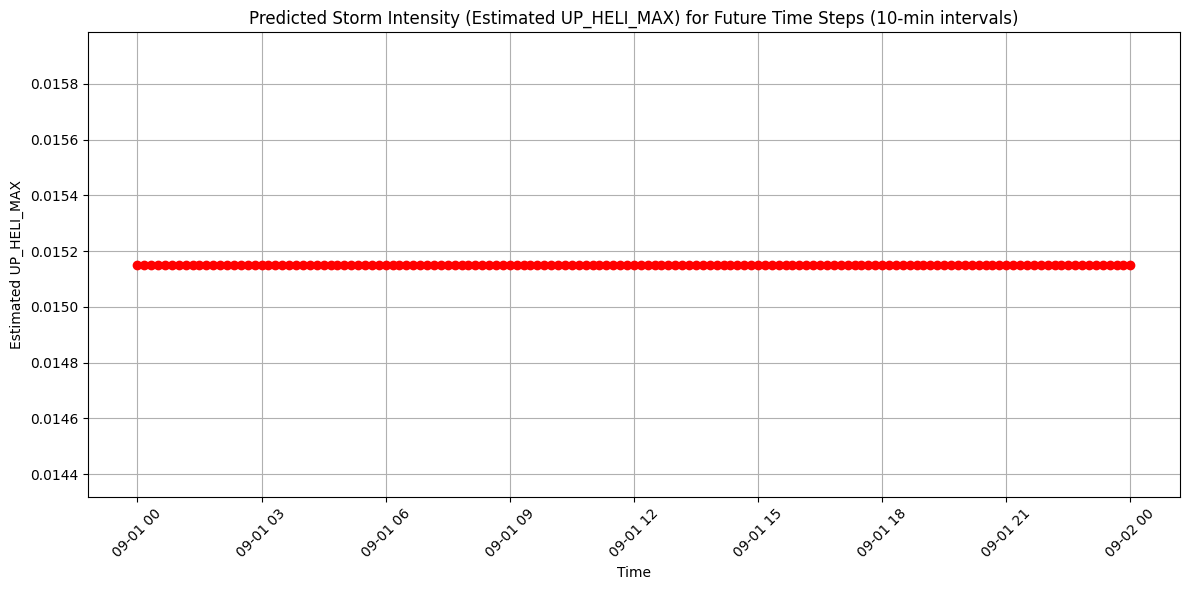


--- Accuracy Readings (LightGBM based on Percentiles for 10-min data) ---
Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3072
           1       0.94      0.94      0.94       235
           2       0.84      0.95      0.89       118
           3       0.86      0.89      0.88        71
           4       0.95      0.91      0.93        46

    accuracy                           0.98      3542
   macro avg       0.92      0.94      0.93      3542
weighted avg       0.99      0.98      0.98      3542


Confusion Matrix:
[[3048    9    9    5    1]
 [   7  222    5    1    0]
 [   0    4  112    2    0]
 [   0    0    7   63    1]
 [   1    0    1    2   42]]


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier # Import LightGBM
import warnings

# Suppress FutureWarning from sklearn
warnings.filterwarnings("ignore", category=FutureWarning)


# --- Data Loading and Preprocessing ---
# Load CSV
df = pd.read_csv("KLBB_wrf_2d_May_Aug1998.csv", encoding='latin1', low_memory=False)
print(f"Shape before handling NaNs: {df.shape}")

# Drop the 'Unnamed: 0' column if it exists
columns_to_drop_initial = ['Unnamed: 0']
df = df.drop(columns=columns_to_drop_initial, errors='ignore')

# Parse 'XTIME' as datetime and set as index if it exists
if 'XTIME' in df.columns:
    df['XTIME'] = pd.to_datetime(df['XTIME'])
    df = df.set_index('XTIME')
else:
    print("Warning: 'XTIME' column not found. Cannot set as index.")


# Drop specified columns
columns_to_drop = ['afwa_tlyrbot', 'afwa_afwa_tlyrtop', 'afwa_turb', 'C1H', 'C2H', 'C1F', 'C2F', 'C3H', 'C4H', 'C3F', 'C4F', 'AFWA_TLYRBOT', 'AFWA_TLYRTOP', 'AFWA_TURB']
df = df.drop(columns=columns_to_drop, errors='ignore')
print(f"Shape after dropping specified columns: {df.shape}")

# Replace placeholder values with NaN
df = df.replace(-9.999000e+30, np.nan)

# Drop any remaining non-numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns
df = df[numeric_cols]
print(f"Shape after dropping non-numeric columns: {df.shape}")

# Fill remaining missing values with the mean
df = df.fillna(df.mean())
print(f"Shape after filling remaining NaNs: {df.shape}")

# Check for remaining NaNs
print("Checking for remaining NaNs:")
print(df.isnull().sum()[df.isnull().sum() > 0])


# --- Create time-based features (10-min intervals) ---
# Only create time-based features if 'XTIME' was successfully set as index
if isinstance(df.index, pd.DatetimeIndex):
    df['hour_of_day'] = df.index.hour
    df['day_of_year'] = df.index.dayofyear

    # Create lagged features for UP_HELI_MAX at 10-minute intervals
    if 'UP_HELI_MAX' in df.columns:
        df['UP_HELI_MAX_lag_1'] = df['UP_HELI_MAX'].shift(1)
        df['UP_HELI_MAX_lag_2'] = df['UP_HELI_MAX'].shift(2)
        df['UP_HELI_MAX_lag_3'] = df['UP_HELI_MAX'].shift(3)

        # Create rolling mean feature for UP_HELI_MAX with a window of 3 at 10-minute intervals
        df['UP_HELI_MAX_rolling_mean_3'] = df['UP_HELI_MAX'].rolling(window=3).mean()

        # Drop rows with NaN values introduced by lagging and rolling mean
        df = df.dropna()
        print("\nHead of DataFrame after creating time-based and lagged features:")
        display(df.head())
    else:
        print("Warning: 'UP_HELI_MAX' column not found. Cannot create lagged or rolling mean features.")
else:
    print("Warning: Time-based features and lagged features cannot be created as 'XTIME' was not set as index.")


# --- Create multi-class target (10-min intervals) ---
# Filter the UP_HELI_MAX column for non-zero values
if 'UP_HELI_MAX' in df.columns:
    y_events = df[df['UP_HELI_MAX'] > 0]['UP_HELI_MAX']

    # Calculate percentile thresholds
    threshold_light_percentile = y_events.quantile(0.50)
    threshold_moderate_percentile = y_events.quantile(0.75)
    threshold_heavy_percentile = y_events.quantile(0.90)

    print(f"\nPercentile thresholds for non-zero UP_HELI_MAX:")
    print(f"50th percentile (potential Light storm threshold): {threshold_light_percentile:.4f}")
    print(f"75th percentile (potential Moderate storm threshold): {threshold_moderate_percentile:.4f}")
    print(f"90th percentile (potential Heavy storm threshold): {threshold_heavy_percentile:.4f}")

    # Define the multi-class target categorization function
    def categorize_storm_intensity_percentile_10min(up_heli_max):
        if up_heli_max == 0:
            return 0 # No storm
        elif up_heli_max <= threshold_light_percentile:
            return 1 # Light storm
        elif up_heli_max <= threshold_moderate_percentile:
            return 2 # Moderate storm
        elif up_heli_max <= threshold_heavy_percentile:
            return 3 # Heavy storm
        else:
            return 4 # Very Heavy Storm

    # Apply the function to create the multi-class target variable
    y_intensity_percentile_reindexed = df['UP_HELI_MAX'].apply(categorize_storm_intensity_percentile_10min)

    # Print the distribution of the new multi-class target variable
    print("\nDistribution of Storm Intensity Categories (based on Percentiles for 10-min data):")
    print(y_intensity_percentile_reindexed.value_counts().sort_index())


    # --- Split data into training and test sets (10-min intervals) ---
    # Define features (X) and target (y)
    X = df.drop(columns=['UP_HELI_MAX'])
    y = y_intensity_percentile_reindexed

    # Split data into training and test sets
    X_train_intensity_perc_10min, X_test_intensity_perc_10min, y_train_intensity_perc_10min, y_test_intensity_perc_10min = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("\nShapes of the resulting splits:")
    print("X_train_intensity_perc_10min:", X_train_intensity_perc_10min.shape)
    print("X_test_intensity_perc_10min:", X_test_intensity_perc_10min.shape)
    print("y_train_intensity_perc_10min:", y_train_intensity_perc_10min.shape)
    print("y_test_intensity_perc_10min:", y_test_intensity_perc_10min.shape)


    # --- Scale features (10-min intervals) ---
    # Instantiate StandardScaler
    scaler_10min = StandardScaler()

    # Fit and transform the training data, transform the test data
    X_train_intensity_perc_10min = scaler_10min.fit_transform(X_train_intensity_perc_10min)
    X_test_intensity_perc_10min = scaler_10min.transform(X_test_intensity_perc_10min)

    print("\nScaling completed.")


    # --- Train multi-class LightGBM classifier (10-min intervals) ---
    lgbm_intensity_classifier_10min = LGBMClassifier(objective='multiclass',
                                                   num_class=len(np.unique(y_train_intensity_perc_10min)),
                                                   metric='multi_logloss',
                                                   random_state=42,
                                                   n_jobs=-1)

    lgbm_intensity_classifier_10min.fit(X_train_intensity_perc_10min, y_train_intensity_perc_10min)

    print("\nLightGBM multi-class classifier (10-min intervals) trained successfully.")


    # --- Evaluate multi-class LightGBM classifier (10-min intervals) ---
    # Predict on the test set
    y_pred_lgbm_intensity_10min = lgbm_intensity_classifier_10min.predict(X_test_intensity_perc_10min)

    # Evaluate the multi-class LightGBM classifier (10-min intervals)
    print("\n--- Multi-class Classification Evaluation (LightGBM based on Percentiles for 10-min data) ---")
    print(f"Accuracy: {accuracy_score(y_test_intensity_perc_10min, y_pred_lgbm_intensity_10min):.2f}")
    print("Classification Report:")
    print(classification_report(y_test_intensity_perc_10min, y_pred_lgbm_intensity_10min))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_intensity_perc_10min, y_pred_lgbm_intensity_10min))


    # --- Prepare future data for prediction (10-min intervals) ---
    # 1. Create a future DataFrame with 10-minute frequency
    last_timestamp = df.index.max()
    future_start_time = last_timestamp + pd.Timedelta(minutes=10)
    future_end_time = future_start_time + pd.Timedelta(hours=24) # Predict 24 hours into the future
    future_time_index = pd.date_range(start=future_start_time, end=future_end_time, freq='10min')

    # Create a future DataFrame with the same columns as the original df, filled with NaNs initially
    df_future_10min = pd.DataFrame(index=future_time_index, columns=df.columns)

    # 2. Reindex the original df to include future timestamps
    df_reindexed_future = df.reindex(df.index.union(df_future_10min.index))

    # Fill NaNs introduced by reindexing with the mean of the original columns
    original_means = df.mean()
    df_reindexed_future = df_reindexed_future.fillna(original_means)

    # 3. Create time-based features for the reindexed DataFrame
    if isinstance(df_reindexed_future.index, pd.DatetimeIndex):
        df_reindexed_future['hour_of_day'] = df_reindexed_future.index.hour
        df_reindexed_future['day_of_year'] = df_reindexed_future.index.dayofyear

        # 4. Create lagged features and rolling mean for the reindexed DataFrame
        if 'UP_HELI_MAX' in df_reindexed_future.columns:
            df_reindexed_future['UP_HELI_MAX_lag_1'] = df_reindexed_future['UP_HELI_MAX'].shift(1)
            df_reindexed_future['UP_HELI_MAX_lag_2'] = df_reindexed_future['UP_HELI_MAX'].shift(2)
            df_reindexed_future['UP_HELI_MAX_lag_3'] = df_reindexed_future['UP_HELI_MAX'].shift(3)
            df_reindexed_future['UP_HELI_MAX_rolling_mean_3'] = df_reindexed_future['UP_HELI_MAX'].rolling(window=3).mean()

            # 5. Fill any NaNs introduced by lagged and rolling mean features
            df_reindexed_future = df_reindexed_future.fillna(df_reindexed_future.mean()) # Fill NaNs after creating lagged features

            # 6. Extract the future data portion
            X_future_10min = df_reindexed_future.loc[future_time_index].drop(columns=['UP_HELI_MAX'])

            print("\nFuture dataset preparation completed.")
            print("Head of X_future_10min:")
            display(X_future_10min.head())
            print("Tail of X_future_10min:")
            display(X_future_10min.tail())

            # 7. Ensure columns match the training data
            # Convert X_train_intensity_perc_10min (numpy array) back to DataFrame to easily compare columns
            X_train_intensity_perc_10min_df = pd.DataFrame(X_train_intensity_perc_10min, columns=X.columns)

            # Align columns - add missing columns to X_future_10min with fill value 0, and drop extra columns
            missing_cols_future = set(X_train_intensity_perc_10min_df.columns) - set(X_future_10min.columns)
            for c in missing_cols_future:
                X_future_10min[c] = 0

            extra_cols_future = set(X_future_10min.columns) - set(X_train_intensity_perc_10min_df.columns)
            X_future_10min = X_future_10min.drop(columns=list(extra_cols_future))

            # Ensure the order of columns is the same
            X_future_10min = X_future_10min[X_train_intensity_perc_10min_df.columns]

            print("\nColumns in X_future_10min after alignment:")
            print(X_future_10min.columns)
            print("\nColumns in X_train_intensity_perc_10min_df:")
            print(X_train_intensity_perc_10min_df.columns)

            print("\nShape of X_future_10min after alignment:", X_future_10min.shape)


            # --- Scale future data (10-min intervals) ---
            X_future_10min = scaler_10min.transform(X_future_10min)
            print("\nFuture data scaled successfully.")


            # --- Predict future storm intensity (10-min intervals) ---
            future_intensity_predictions_10min = lgbm_intensity_classifier_10min.predict(X_future_10min)

            print("\nStorm intensity predictions for future data have been made.")


            # --- Map predicted intensity to a single metric (10-min intervals) ---
            # Calculate mean UP_HELI_MAX for each intensity category using the 10-min training data
            mean_up_heli_max_by_category_10min = df['UP_HELI_MAX'].groupby(y_intensity_percentile_reindexed).mean()
            print("\nMean UP_HELI_MAX by Storm Intensity Category (10-min data):")
            print(mean_up_heli_max_by_category_10min)

            # Create a Series to store estimated UP_HELI_MAX for future time steps using the original future index
            future_estimated_up_heli_max_10min = pd.Series(index=df_future_10min.index)

            # Map the predicted intensity categories to the mean UP_HELI_MAX values
            future_estimated_up_heli_max_10min = pd.Series(future_intensity_predictions_10min, index=df_future_10min.index).map(mean_up_heli_max_by_category_10min)

            # Print the head of the estimated UP_HELI_MAX for future steps
            print("\nEstimated UP_HELI_MAX for future time steps (10-min intervals):")
            display(future_estimated_up_heli_max_10min.head())


            # --- Identify predicted storm instances (10-min intervals) ---
            # 1. Create a boolean mask for predicted storm instances
            storm_mask_10min = future_intensity_predictions_10min > 0

            # 2. Filter the X_future_10min (NumPy array) using the mask
            X_predicted_storms_10min_array = X_future_10min[storm_mask_10min]

            # 3. Create a DataFrame from the filtered features, using the index from the original df_future_10min filtered by the same mask
            # Use the columns from the original X DataFrame
            X_predicted_storms_10min = pd.DataFrame(X_predicted_storms_10min_array, index=df_future_10min.index[storm_mask_10min], columns=X.columns)

            # 4. Filter the future_estimated_up_heli_max_storms_10min Series using the same boolean mask
            future_estimated_up_heli_max_storms_10min = future_estimated_up_heli_max_10min[storm_mask_10min]

            # 5. Print the number of predicted storm instances and display the head of the filtered data
            print(f"\nNumber of predicted storm instances (10-min intervals): {X_predicted_storms_10min.shape[0]}")
            print("\nHead of X_predicted_storms_10min:")
            display(X_predicted_storms_10min.head())
            print("\nHead of future_estimated_up_heli_max_storms_10min:")
            display(future_estimated_up_heli_max_storms_10min.head())


            # --- Visualize future storm predictions (10-min intervals) ---
            print("\n--- Visualizing Future Storm Predictions (10-min intervals) ---")

            if not future_estimated_up_heli_max_storms_10min.empty:
                plt.figure(figsize=(12, 6))
                plt.plot(future_estimated_up_heli_max_storms_10min.index, future_estimated_up_heli_max_storms_10min.values, marker='o', linestyle='-', color='red')
                plt.title('Predicted Storm Intensity (Estimated UP_HELI_MAX) for Future Time Steps (10-min intervals)')
                plt.xlabel('Time')
                plt.ylabel('Estimated UP_HELI_MAX')
                plt.grid(True)
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
            else:
                print("No storms predicted in the future time steps to visualize.")

            # --- Display Accuracy Readings (10-min intervals) ---
            print("\n--- Accuracy Readings (LightGBM based on Percentiles for 10-min data) ---")
            print(f"Accuracy: {accuracy_score(y_test_intensity_perc_10min, y_pred_lgbm_intensity_10min):.2f}")
            print("\nClassification Report:")
            print(classification_report(y_test_intensity_perc_10min, y_pred_lgbm_intensity_10min))
            print("\nConfusion Matrix:")
            print(confusion_matrix(y_test_intensity_perc_10min, y_pred_lgbm_intensity_10min))
        else:
            print("Warning: 'UP_HELI_MAX' column not found in the reindexed DataFrame. Cannot prepare future data for prediction.")
    else:
        print("Warning: Cannot prepare future data for prediction as the DataFrame index is not a DatetimeIndex.")
else:
    print("Warning: 'UP_HELI_MAX' column not found. Cannot create multi-class target or proceed with modeling.")

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier # Import LightGBM
import warnings

# Suppress FutureWarning from sklearn
warnings.filterwarnings("ignore", category=FutureWarning)

# Load and preprocess data
df = pd.read_csv("KLBB_wrf_2d_May_Aug1998.csv", encoding='latin1', low_memory=False)

# Drop the 'Unnamed: 0' column if it exists
columns_to_drop_initial = ['Unnamed: 0']
df = df.drop(columns=columns_to_drop_initial, errors='ignore')

# Convert 'XTIME' to datetime and set as index if it exists
if 'XTIME' in df.columns:
    df['XTIME'] = pd.to_datetime(df['XTIME'])
    df = df.set_index('XTIME')
else:
    print("Warning: 'XTIME' column not found. Cannot set as index.")

# Drop specified columns
columns_to_drop = ['afwa_tlyrbot', 'afwa_afwa_tlyrtop', 'afwa_turb', 'C1H', 'C2H', 'C1F', 'C2F', 'C3H', 'C4H', 'C3F', 'C4F', 'AFWA_TLYRBOT', 'AFWA_TLYRTOP', 'AFWA_TURB']
df = df.drop(columns=columns_to_drop, errors='ignore')

# Replace placeholder values with NaN
df = df.replace(-9.999000e+30, np.nan)

# Drop any remaining non-numeric columns
numeric_cols = df.select_dtypes(include=np.number).columns
df = df[numeric_cols]

# Fill remaining missing values with the mean
df = df.fillna(df.mean())

# Create time-based features if the index is a DatetimeIndex
if isinstance(df.index, pd.DatetimeIndex):
    df['hour_of_day'] = df.index.hour
    df['day_of_year'] = df.index.dayofyear

    # Create lagged features for UP_HELI_MAX at 10-minute intervals if 'UP_HELI_MAX' exists
    if 'UP_HELI_MAX' in df.columns:
        df['UP_HELI_MAX_lag_1'] = df['UP_HELI_MAX'].shift(1)
        df['UP_HELI_MAX_lag_2'] = df['UP_HELI_MAX'].shift(2)
        df['UP_HELI_MAX_lag_3'] = df['UP_HELI_MAX'].shift(3)

        # Create rolling mean feature for UP_HELI_MAX with a window of 3 at 10-minute intervals
        df['UP_HELI_MAX_rolling_mean_3'] = df['UP_HELI_MAX'].rolling(window=3).mean()

        # Drop rows with NaN values introduced by lagging and rolling mean
        df = df.dropna()

        print("Data loading, preprocessing, and feature creation complete.")
        print(f"Shape of the final DataFrame: {df.shape}")
        display(df.head())

        # Define the multi-class target categorization function (assuming it's the same as before)
        # This function needs to be defined once before the loop
        def categorize_storm_intensity_percentile_10min(up_heli_max):
            # Assuming percentile thresholds were calculated earlier in the notebook
            # If not, they need to be calculated here based on the non-zero UP_HELI_MAX of the *original* df
            # For consistency, let's recalculate them here based on the df after initial cleaning but before lagging
            df_original_cleaned = pd.read_csv("KLBB_wrf_2d_May_Aug1998.csv", encoding='latin1', low_memory=False)
            columns_to_drop_initial_cleaned = ['Unnamed: 0']
            df_original_cleaned = df_original_cleaned.drop(columns=columns_to_drop_initial_cleaned, errors='ignore')

            if 'XTIME' in df_original_cleaned.columns:
                df_original_cleaned['XTIME'] = pd.to_datetime(df_original_cleaned['XTIME'])
                df_original_cleaned = df_original_cleaned.set_index('XTIME')
            else:
                 print("Warning: 'XTIME' column not found in original cleaned df. Cannot set as index.")


            columns_to_drop_cleaned = ['afwa_tlyrbot', 'afwa_afwa_tlyrtop', 'afwa_turb', 'C1H', 'C2H', 'C1F', 'C2F', 'C3H', 'C4H', 'C3F', 'C4F', 'AFWA_TLYRBOT', 'AFWA_TLYRTOP', 'AFWA_TURB']
            df_original_cleaned = df_original_cleaned.drop(columns=columns_to_drop_cleaned, errors='ignore')
            df_original_cleaned = df_original_cleaned.replace(-9.999000e+30, np.nan)
            numeric_cols_original = df_original_cleaned.select_dtypes(include=np.number).columns
            df_original_cleaned = df_original_cleaned[numeric_cols_original]
            df_original_cleaned = df_original_cleaned.fillna(df_original_cleaned.mean())

            if 'UP_HELI_MAX' in df_original_cleaned.columns:
                 y_events_original = df_original_cleaned[df_original_cleaned['UP_HELI_MAX'] > 0]['UP_HELI_MAX']

                 threshold_light_percentile = y_events_original.quantile(0.50)
                 threshold_moderate_percentile = y_events_original.quantile(0.75)
                 threshold_heavy_percentile = y_events_original.quantile(0.90)


                 if up_heli_max == 0:
                     return 0 # No storm
                 elif up_heli_max <= threshold_light_percentile:
                     return 1 # Light storm
                 elif up_heli_max <= threshold_moderate_percentile:
                     return 2 # Moderate storm
                 elif up_heli_max <= threshold_heavy_percentile:
                     return 3 # Heavy storm
                 else:
                     return 4 # Very Heavy Storm
            else:
                print("Warning: 'UP_HELI_MAX' column not found in original cleaned df. Cannot categorize storm intensity.")
                return np.nan


        # Define prediction horizons
        prediction_horizons_hours = [3, 6, 12]
        interval_minutes = 10
        prediction_horizons_intervals = [int(h * 60 / interval_minutes) for h in prediction_horizons_hours]

        # Store evaluation metrics for each horizon
        evaluation_results = {}

        # Iterate through each defined prediction horizon (in intervals)
        for shift_intervals in prediction_horizons_intervals:
            prediction_horizon_hours = int(shift_intervals * interval_minutes / 60)
            print(f"\n--- Processing Prediction Horizon: {prediction_horizon_hours} hours ({shift_intervals} intervals) ---")

            # Create a new target column by shifting UP_HELI_MAX
            df_shifted = df.copy()
            df_shifted['UP_HELI_MAX_future'] = df_shifted['UP_HELI_MAX'].shift(-shift_intervals)

            # Apply the categorize_storm_intensity_percentile_10min function to the future target
            y_intensity_percentile_future = df_shifted['UP_HELI_MAX_future'].apply(categorize_storm_intensity_percentile_10min)

            # Drop rows where the future target is NaN (due to shifting)
            df_future_target = df_shifted.copy()
            df_future_target['y_intensity_percentile_future'] = y_intensity_percentile_future
            df_future_target = df_future_target.dropna(subset=['y_intensity_percentile_future'])

            y_current_horizon = df_future_target['y_intensity_percentile_future']
            X_current_horizon = df_future_target.drop(columns=['UP_HELI_MAX', 'UP_HELI_MAX_future', 'y_intensity_percentile_future'])

            # Print the distribution of the newly created multi-class target variable
            print(f"\nDistribution of Storm Intensity Categories for {prediction_horizon_hours}-hour future:")
            print(y_current_horizon.value_counts().sort_index())


            # Split data into training and test sets for the current horizon
            X_train_current, X_test_current, y_train_current, y_test_current = train_test_split(
                X_current_horizon, y_current_horizon,
                test_size=0.2,
                random_state=42,
                stratify=y_current_horizon # Stratify by the multi-class target
            )

            print("\nShapes of the resulting splits:")
            print("X_train_current:", X_train_current.shape)
            print("X_test_current:", X_test_current.shape)
            print("y_train_current:", y_train_current.shape)
            print("y_test_current:", y_test_current.shape)

            # Scale features for the current horizon
            scaler_current = StandardScaler()
            X_train_current_scaled = scaler_current.fit_transform(X_train_current)
            X_test_current_scaled = scaler_current.transform(X_test_current)
            print("\nScaling completed.")

            # Train a Multi-class LightGBM Classifier for the current horizon
            lgbm_current_classifier = LGBMClassifier(objective='multiclass',
                                                    num_class=len(np.unique(y_train_current)),
                                                    metric='multi_logloss',
                                                    random_state=42,
                                                    n_jobs=-1)

            lgbm_current_classifier.fit(X_train_current_scaled, y_train_current)
            print(f"\nLightGBM classifier for {prediction_horizon_hours}-hour prediction trained successfully.")

            # Evaluate the classifier for the current horizon
            y_pred_current = lgbm_current_classifier.predict(X_test_current_scaled)

            # Store evaluation metrics
            horizon_key = f"{prediction_horizon_hours} hours"
            evaluation_results[horizon_key] = {
                'accuracy': accuracy_score(y_test_current, y_pred_current),
                'classification_report': classification_report(y_test_current, y_pred_current), # Store as string
                'confusion_matrix': confusion_matrix(y_test_current, y_pred_current).tolist() # Convert to list for easy printing
            }


        print("\n--- Summary of Evaluation Results for All Prediction Horizons ---")

        # Display the stored evaluation metrics for each prediction horizon
        for horizon, metrics in evaluation_results.items():
            print(f"\n--- Results for {horizon} ---")
            print(f"Accuracy: {metrics['accuracy']:.2f}")
            print("Classification Report:")
            print(metrics['classification_report']) # Print the stored string classification report

            print("Confusion Matrix:")
            print(np.array(metrics['confusion_matrix'])) # Convert back to numpy array for better display

        print("\n--- All prediction horizons processed ---")
    else:
        print("Warning: 'UP_HELI_MAX' column not found. Cannot create lagged or rolling mean features or proceed with modeling.")
else:
    print("Warning: Time-based features, lagged features, and modeling cannot be performed as 'XTIME' was not set as index.")

Data loading, preprocessing, and feature creation complete.
Shape of the final DataFrame: (17709, 62)


,T2,U10,V10,LPI,GRDFLX,SNOW,SNOWH,RAINC,RAINNC,I_RAINC,...,AFWA_PWAT,AFWA_HAIL,AFWA_LLWS,AFWA_TORNADO,hour_of_day,day_of_year,UP_HELI_MAX_lag_1,UP_HELI_MAX_lag_2,UP_HELI_MAX_lag_3,UP_HELI_MAX_rolling_mean_3
XTIME,,,,,,,,,,,,,,,,,,,,,
1998-05-01 00:30:00,292.87885,-1.043371,-1.705118,0.0,-77.119610,0.0,0.0,0.0,70.53873,0,...,18.074863,0.0,6.829694,0.0,0,121,0.0,0.0,0.311277,0.0
1998-05-01 00:40:00,292.84930,-0.130308,-1.011914,0.0,-76.715870,0.0,0.0,0.0,70.53873,0,...,19.016418,0.0,6.829694,0.0,0,121,0.0,0.0,0.000000,0.0
1998-05-01 00:50:00,292.83685,-1.044217,-0.438248,0.0,-81.800316,0.0,0.0,0.0,70.53873,0,...,19.101862,0.0,6.829694,0.0,0,121,0.0,0.0,0.000000,0.0
1998-05-01 01:00:00,292.67468,-1.377092,-0.128043,0.0,-85.201500,0.0,0.0,0.0,70.53873,0,...,19.567842,0.0,6.829694,0.0,1,121,0.0,0.0,0.000000,0.0
1998-05-01 01:10:00,292.56458,-1.050332,0.218581,0.0,-86.397545,0.0,0.0,0.0,70.53873,0,...,20.019844,0.0,6.101421,0.0,1,121,0.0,0.0,0.000000,0.0



--- Processing Prediction Horizon: 3 hours (18 intervals) ---

Distribution of Storm Intensity Categories for 3-hour future:
y_intensity_percentile_future
0    15343
1     1180
2      583
3      355
4      248
Name: count, dtype: int64

Shapes of the resulting splits:
X_train_current: (14167, 61)
X_test_current: (3542, 61)
y_train_current: (14167,)
y_test_current: (3542,)

Scaling completed.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9830
[LightGBM] [Info] Number of data points in the train set: 14167, number of used features: 47
[LightGBM] [Info] Start training from score -0.143432
[LightGBM] [Info] Start training from score -2.708544
[LightGBM] [Info] Start training from score -3.414485
[LightGBM] [Info] Start training from score -3.909696
[LightGBM] [Info] Start training from score -4.265366

LightGBM classifier for 3-hour prediction tr

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
import warnings

# Suppress FutureWarning from sklearn
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Data Loading and Preprocessing ---
def load_and_preprocess_data(file_path):
    """Loads, preprocesses data, and creates time-based and lagged features."""
    try:
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path, encoding='latin1', low_memory=False)
        elif file_path.endswith('.parquet'):
            df = pd.read_parquet(file_path)
        else:
            print(f"Unsupported file format for {file_path}")
            return None

    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error loading data from {file_path}: {e}")
        return None


    columns_to_drop_initial = ['Unnamed: 0']
    df = df.drop(columns=columns_to_drop_initial, errors='ignore')

    if 'XTIME' in df.columns:
        df['XTIME'] = pd.to_datetime(df['XTIME'])
        df = df.set_index('XTIME')
    else:
        print(f"Warning: 'XTIME' column not found in {file_path}. Cannot set as index.")
        return None

    columns_to_drop = ['afwa_tlyrbot', 'afwa_afwa_tlyrtop', 'afwa_turb', 'C1H', 'C2H', 'C1F', 'C2F', 'C3H', 'C4H', 'C3F', 'C4F', 'AFWA_TLYRBOT', 'AFWA_TLYRTOP', 'AFWA_TURB']
    df = df.drop(columns=columns_to_drop, errors='ignore')

    df = df.replace(-9.999000e+30, np.nan)

    numeric_cols = df.select_dtypes(include=np.number).columns
    df = df[numeric_cols]

    df = df.fillna(df.mean())

    if isinstance(df.index, pd.DatetimeIndex):
        df['hour_of_day'] = df.index.hour
        df['day_of_year'] = df.index.dayofyear

        if 'UP_HELI_MAX' in df.columns:
            df['UP_HELI_MAX_lag_1'] = df['UP_HELI_MAX'].shift(1)
            df['UP_HELI_MAX_lag_2'] = df['UP_HELI_MAX'].shift(2)
            df['UP_HELI_MAX_lag_3'] = df['UP_HELI_MAX'].shift(3)
            df['UP_HELI_MAX_rolling_mean_3'] = df['UP_HELI_MAX'].rolling(window=3).mean()
            df = df.dropna()
            return df
        else:
            print(f"Warning: 'UP_HELI_MAX' column not found in {file_path}. Cannot create lagged features.")
            return None
    else:
        print(f"Warning: Time-based features and lagged features cannot be created for {file_path} as 'XTIME' was not set as index.")
        return None

# --- Multi-class Classification Target Creation (based on Percentiles) ---
def categorize_storm_intensity_percentile(up_heli_max, original_df_cleaned):
    """Categorizes storm intensity based on percentiles of non-zero UP_HELI_MAX."""
    if 'UP_HELI_MAX' in original_df_cleaned.columns:
        y_events_original = original_df_cleaned[original_df_cleaned['UP_HELI_MAX'] > 0]['UP_HELI_MAX']

        if not y_events_original.empty:
            threshold_light_percentile = y_events_original.quantile(0.50)
            threshold_moderate_percentile = y_events_original.quantile(0.75)
            threshold_heavy_percentile = y_events_original.quantile(0.90)

            if up_heli_max == 0:
                return 0  # No storm
            elif up_heli_max <= threshold_light_percentile:
                return 1  # Light storm
            elif up_heli_max <= threshold_moderate_percentile:
                return 2  # Moderate storm
            elif up_heli_max <= threshold_heavy_percentile:
                return 3  # Heavy storm
            else:
                return 4  # Very Heavy Storm
        else:
             return 0 # No storms found in original data
    else:
        print("Warning: 'UP_HELI_MAX' column not found in original cleaned df. Cannot categorize storm intensity.")
        return np.nan


# --- Function to train and evaluate model for a given horizon ---
def train_and_evaluate_horizon(df, shift_intervals, original_df_cleaned):
    """Trains and evaluates LightGBM model for a specific prediction horizon."""
    prediction_horizon_hours = int(shift_intervals * 10 / 60)
    print(f"\n--- Processing Prediction Horizon: {prediction_horizon_hours} hours ({shift_intervals} intervals) ---")

    df_shifted = df.copy()
    df_shifted['UP_HELI_MAX_future'] = df_shifted['UP_HELI_MAX'].shift(-shift_intervals)

    y_intensity_percentile_future = df_shifted['UP_HELI_MAX_future'].apply(lambda x: categorize_storm_intensity_percentile(x, original_df_cleaned))

    df_future_target = df_shifted.copy()
    df_future_target['y_intensity_percentile_future'] = y_intensity_percentile_future
    df_future_target = df_future_target.dropna(subset=['y_intensity_percentile_future'])

    y_current_horizon = df_future_target['y_intensity_percentile_future']
    X_current_horizon = df_future_target.drop(columns=['UP_HELI_MAX', 'UP_HELI_MAX_future', 'y_intensity_percentile_future'])

    print(f"\nDistribution of Storm Intensity Categories for {prediction_horizon_hours}-hour future:")
    print(y_current_horizon.value_counts().sort_index())

    if X_current_horizon.empty or y_current_horizon.empty or len(np.unique(y_current_horizon)) < 2:
        print(f"Insufficient data or target classes for {prediction_horizon_hours}-hour prediction. Skipping.")
        return None, None, None, None, None, None

    X_train_current, X_test_current, y_train_current, y_test_current = train_test_split(
        X_current_horizon, y_current_horizon,
        test_size=0.2,
        random_state=42,
        stratify=y_current_horizon
    )

    scaler_current = StandardScaler()
    X_train_current_scaled = scaler_current.fit_transform(X_train_current)
    X_test_current_scaled = scaler_current.transform(X_test_current)

    lgbm_current_classifier = LGBMClassifier(objective='multiclass',
                                            num_class=len(np.unique(y_train_current)),
                                            metric='multi_logloss',
                                            random_state=42,
                                            n_jobs=-1)

    lgbm_current_classifier.fit(X_train_current_scaled, y_train_current)

    y_pred_current = lgbm_current_classifier.predict(X_test_current_scaled)

    evaluation_metrics = {
        'accuracy': accuracy_score(y_test_current, y_pred_current),
        'classification_report': classification_report(y_test_current, y_pred_current),
        'confusion_matrix': confusion_matrix(y_test_current, y_pred_current).tolist()
    }

    return evaluation_metrics, lgbm_current_classifier, scaler_current, X_current_horizon.columns, df_future_target.index.max(), df_future_target # Return last timestamp and df_future_target


# --- Function to prepare future data for prediction ---
def prepare_future_data(df, scaler, original_columns, last_timestamp):
    """Prepares future data for prediction."""
    future_start_time = last_timestamp + pd.Timedelta(minutes=10)
    future_end_time = future_start_time + pd.Timedelta(hours=24)
    future_time_index = pd.date_range(start=future_start_time, end=future_end_time, freq='10min')

    df_future = pd.DataFrame(index=future_time_index, columns=df.columns)

    df_reindexed_future = df.reindex(df.index.union(df_future.index))

    original_means = df.mean()
    df_reindexed_future = df_reindexed_future.fillna(original_means)

    if isinstance(df_reindexed_future.index, pd.DatetimeIndex):
        df_reindexed_future['hour_of_day'] = df_reindexed_future.index.hour
        df_reindexed_future['day_of_year'] = df_reindexed_future.index.dayofyear

        if 'UP_HELI_MAX' in df_reindexed_future.columns:
            df_reindexed_future['UP_HELI_MAX_lag_1'] = df_reindexed_future['UP_HELI_MAX'].shift(1)
            df_reindexed_future['UP_HELI_MAX_lag_2'] = df_reindexed_future['UP_HELI_MAX'].shift(2)
            df_reindexed_future['UP_HELI_MAX_lag_3'] = df_reindexed_future['UP_HELI_MAX'].shift(3)
            df_reindexed_future['UP_HELI_MAX_rolling_mean_3'] = df_reindexed_future['UP_HELI_MAX'].rolling(window=3).mean()

            df_reindexed_future = df_reindexed_future.fillna(df_reindexed_future.mean())

            X_future = df_reindexed_future.loc[future_time_index].drop(columns=['UP_HELI_MAX'])

            # Align columns
            X_future = X_future.reindex(columns=original_columns, fill_value=0)

            X_future_scaled = scaler.transform(X_future)

            return X_future_scaled, future_time_index, df_reindexed_future # Return df_reindexed_future for mean calculation
        else:
            print("Warning: 'UP_HELI_MAX' column not found in the reindexed DataFrame. Cannot prepare future data.")
            return None, None, None
    else:
        print("Warning: Cannot prepare future data for prediction as the DataFrame index is not a DatetimeIndex.")
        return None, None, None


# --- Function to predict and visualize future storm intensity ---
def predict_and_visualize_future(lgbm_classifier, X_future_scaled, future_time_index, df_for_mean, original_df_cleaned):
    """Predicts and visualizes future storm intensity."""
    if lgbm_classifier is None or X_future_scaled is None or future_time_index is None or df_for_mean is None or original_df_cleaned is None:
        print("Skipping future prediction and visualization due to missing inputs.")
        return

    future_intensity_predictions = lgbm_classifier.predict(X_future_scaled)

    # Calculate mean UP_HELI_MAX for each intensity category using the original data (for consistency)
    if 'UP_HELI_MAX' in original_df_cleaned.columns:
        y_intensity_original = original_df_cleaned['UP_HELI_MAX'].apply(lambda x: categorize_storm_intensity_percentile(x, original_df_cleaned))
        mean_up_heli_max_by_category = original_df_cleaned['UP_HELI_MAX'].groupby(y_intensity_original).mean()

        future_estimated_up_heli_max = pd.Series(future_intensity_predictions, index=future_time_index).map(mean_up_heli_max_by_category)

        storm_mask = future_intensity_predictions > 0
        future_estimated_up_heli_max_storms = future_estimated_up_heli_max[storm_mask]

        print(f"\nNumber of predicted storm instances in future: {future_estimated_up_heli_max_storms.shape[0]}")

        print("\n--- Visualizing Future Storm Predictions ---")
        if not future_estimated_up_heli_max_storms.empty:
            plt.figure(figsize=(12, 6))
            plt.plot(future_estimated_up_heli_max_storms.index, future_estimated_up_heli_max_storms.values, marker='o', linestyle='-', color='red')
            plt.title('Predicted Storm Intensity (Estimated UP_HELI_MAX) for Future Time Steps')
            plt.xlabel('Time')
            plt.ylabel('Estimated UP_HELI_MAX')
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
        else:
            print("No storms predicted in the future time steps to visualize.")
    else:
        print("Warning: 'UP_HELI_MAX' column not found in the original cleaned data. Cannot map predicted intensity to estimated UP_HELI_MAX.")


# --- Function to train and evaluate model for current storm detection ---
def train_and_evaluate_current(df, original_df_cleaned):
    """Trains and evaluates LightGBM model for current storm detection."""
    print("\n--- Processing Current Storm Detection ---")

    if 'UP_HELI_MAX' not in df.columns:
        print("Warning: 'UP_HELI_MAX' column not found in the DataFrame. Cannot perform current storm detection.")
        return None

    # Create the target variable for current storm intensity
    y_current_intensity = df['UP_HELI_MAX'].apply(lambda x: categorize_storm_intensity_percentile(x, original_df_cleaned))

    # Define features (X) and target (y) for current detection
    X_current = df.drop(columns=['UP_HELI_MAX'])
    y_current = y_current_intensity

    print("\nDistribution of Storm Intensity Categories for Current Detection:")
    print(y_current.value_counts().sort_index())

    if X_current.empty or y_current.empty or len(np.unique(y_current)) < 2:
        print("Insufficient data or target classes for current storm detection. Skipping.")
        return None

    # Split data into training and test sets
    X_train_current, X_test_current, y_train_current, y_test_current = train_test_split(
        X_current, y_current,
        test_size=0.2,
        random_state=42,
        stratify=y_current
    )

    print("\nShapes of the resulting splits for current detection:")
    print("X_train_current:", X_train_current.shape)
    print("X_test_current:", X_test_current.shape)
    print("y_train_current:", y_train_current.shape)
    print("y_test_current:", y_test_current.shape)


    # Scale features
    scaler_current = StandardScaler()
    X_train_current_scaled = scaler_current.fit_transform(X_train_current)
    X_test_current_scaled = scaler_current.transform(X_test_current)
    print("\nScaling completed for current detection.")

    # Train a Multi-class LightGBM Classifier
    lgbm_current_classifier = LGBMClassifier(objective='multiclass',
                                            num_class=len(np.unique(y_train_current)),
                                            metric='multi_logloss',
                                            random_state=42,
                                            n_jobs=-1)

    lgbm_current_classifier.fit(X_train_current_scaled, y_train_current)
    print("\nLightGBM classifier for current storm detection trained successfully.")

    # Evaluate the classifier
    y_pred_current = lgbm_current_classifier.predict(X_test_current_scaled)

    evaluation_metrics = {
        'accuracy': accuracy_score(y_test_current, y_pred_current),
        'classification_report': classification_report(y_test_current, y_pred_current),
        'confusion_matrix': confusion_matrix(y_test_current, y_pred_current).tolist()
    }

    return evaluation_metrics


# --- Main Execution ---
file_path = "/content/KLBB_wrf_2d_MayAug_allYears.parquet" # Replace with your file path

print(f"Processing data from: {file_path}")

# Load and preprocess data
df = load_and_preprocess_data(file_path)

if df is not None and 'UP_HELI_MAX' in df.columns:
    # Create a cleaned version of the original df for percentile calculations
    original_df_cleaned = load_and_preprocess_data(file_path)

    if original_df_cleaned is not None and 'UP_HELI_MAX' in original_df_cleaned.columns:
        # --- Evaluate Current Storm Detection ---
        current_detection_metrics = train_and_evaluate_current(df, original_df_cleaned)

        if current_detection_metrics is not None:
            print("\n--- Current Storm Detection Evaluation Results ---")
            print(f"Accuracy: {current_detection_metrics['accuracy']:.2f}")
            print("Classification Report:")
            print(current_detection_metrics['classification_report'])
            print("Confusion Matrix:")
            print(np.array(current_detection_metrics['confusion_matrix']))


        # --- Evaluate Prediction Horizons (Optional, can be commented out if only current detection is needed) ---
        # Define prediction horizons in terms of 10-minute intervals
        prediction_horizons_intervals = [18, 36, 72] # 3 hours, 6 hours, 12 hours

        # Store evaluation results and models for each horizon
        evaluation_results = {}
        trained_models = {}
        scalers = {}
        training_columns = {}
        last_timestamps = {}
        dfs_for_mean = {}


        # Iterate through each defined prediction horizon
        for shift_intervals in prediction_horizons_intervals:
            eval_metrics, model, scaler, cols, last_ts, df_ft = train_and_evaluate_horizon(df, shift_intervals, original_df_cleaned)
            prediction_horizon_hours = int(shift_intervals * 10 / 60)
            horizon_key = f"{prediction_horizon_hours} hours"

            if eval_metrics is not None:
                evaluation_results[horizon_key] = eval_metrics
                trained_models[horizon_key] = model
                scalers[horizon_key] = scaler
                training_columns[horizon_key] = cols
                last_timestamps[horizon_key] = last_ts
                dfs_for_mean[horizon_key] = df_ft


        # --- Summary of Evaluation Results for All Prediction Horizons ---
        print("\n--- Summary of Evaluation Results for All Prediction Horizons ---")
        for horizon, metrics in evaluation_results.items():
            print(f"\n--- Results for {horizon} ---")
            print(f"Accuracy: {metrics['accuracy']:.2f}")
            print("Classification Report:")
            print(metrics['classification_report'])
            print("Confusion Matrix:")
            print(np.array(metrics['confusion_matrix']))

        # --- Predict and Visualize Future Storm Intensity for a specific horizon (e.g., 3 hours) ---
        predict_horizon_hours = 3 # Change this to the horizon you want to visualize
        predict_horizon_key = f"{predict_horizon_hours} hours"

        if predict_horizon_key in trained_models:
            print(f"\n--- Predicting and Visualizing Future Storm Intensity for {predict_horizon_key} ---")
            lgbm_classifier_future = trained_models[predict_horizon_key]
            scaler_future = scalers[predict_horizon_key]
            training_cols_future = training_columns[predict_horizon_key]
            last_ts_future = last_timestamps[predict_horizon_key]
            df_for_mean_future = dfs_for_mean[predict_horizon_key]

            X_future_scaled, future_time_index, df_reindexed_future = prepare_future_data(df, scaler_future, training_cols_future, last_ts_future)

            predict_and_visualize_future(lgbm_classifier_future, X_future_scaled, future_time_index, df_reindexed_future, original_df_cleaned)
        else:
            print(f"\nPrediction horizon '{predict_horizon_key}' not found in trained models. Cannot predict future.")
    else:
        print("Original cleaned data could not be prepared. Cannot proceed with modeling.")

else:
    print("Data loading or preprocessing failed, or 'UP_HELI_MAX' column is missing. Cannot proceed with modeling.")

Processing data from: /content/KLBB_wrf_2d_MayAug_allYears.parquet

--- Processing Current Storm Detection ---

Distribution of Storm Intensity Categories for Current Detection:
UP_HELI_MAX
0    30081
1     2526
2     1265
3      760
4      501
Name: count, dtype: int64

Shapes of the resulting splits for current detection:
X_train_current: (28106, 61)
X_test_current: (7027, 61)
y_train_current: (28106,)
y_test_current: (7027,)

Scaling completed for current detection.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10083
[LightGBM] [Info] Number of data points in the train set: 28106, number of used features: 52
[LightGBM] [Info] Start training from score -0.155266
[LightGBM] [Info] Start training from score -2.632391
[LightGBM] [Info] Start training from score -3.324055
[LightGBM] [Info] Start training from score -3.833563
[LightGBM] [Info] St

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Distribution of Storm Intensity Categories for 3-hour future:
y_intensity_percentile_future
0    30080
1     2526
2     1265
3      756
4      506
Name: count, dtype: int64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10079
[LightGBM] [Info] Number of data points in the train set: 28106, number of used features: 52
[LightGBM] [Info] Start training from score -0.155308
[LightGBM] [Info] Start training from score -2.632391
[LightGBM] [Info] Start training from score -3.324055
[LightGBM] [Info] Start training from score -3.838510
[LightGBM] [Info] Start training from score -4.239851


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Processing Prediction Horizon: 6 hours (36 intervals) ---

Distribution of Storm Intensity Categories for 6-hour future:
y_intensity_percentile_future
0    30077
1     2515
2     1265
3      752
4      524
Name: count, dtype: int64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10071
[LightGBM] [Info] Number of data points in the train set: 28106, number of used features: 52
[LightGBM] [Info] Start training from score -0.155391
[LightGBM] [Info] Start training from score -2.636854
[LightGBM] [Info] Start training from score -3.324055
[LightGBM] [Info] Start training from score -3.843481
[LightGBM] [Info] Start training from score -4.205867


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Processing Prediction Horizon: 12 hours (72 intervals) ---

Distribution of Storm Intensity Categories for 12-hour future:
y_intensity_percentile_future
0    30045
1     2511
2     1265
3      752
4      560
Name: count, dtype: int64
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10083
[LightGBM] [Info] Number of data points in the train set: 28106, number of used features: 52
[LightGBM] [Info] Start training from score -0.156430
[LightGBM] [Info] Start training from score -2.638346
[LightGBM] [Info] Start training from score -3.324055
[LightGBM] [Info] Start training from score -3.845143
[LightGBM] [Info] Start training from score -4.138945


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Summary of Evaluation Results for All Prediction Horizons ---

--- Results for 3 hours ---
Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6017
           1       0.89      0.31      0.46       505
           2       0.86      0.46      0.60       253
           3       0.80      0.49      0.61       151
           4       0.86      0.75      0.80       101

    accuracy                           0.91      7027
   macro avg       0.87      0.60      0.69      7027
weighted avg       0.91      0.91      0.90      7027

Confusion Matrix:
[[5978   14   11   10    4]
 [ 340  158    5    2    0]
 [ 129    5  117    2    0]
 [  66    0    3   74    8]
 [  21    0    0    4   76]]

--- Results for 6 hours ---
Accuracy: 0.91
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95      6016
           1       0.91      0.34      0.5

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Number of predicted storm instances in future: 0

--- Visualizing Future Storm Predictions ---
No storms predicted in the future time steps to visualize.
